In [1]:
import boto3
import pandas as pd
import numpy as np
import re
from sagemaker import get_execution_role

import matplotlib.pyplot as plt
from tqdm import tqdm

role = get_execution_role()
s3 = boto3.resource('s3')

In [2]:
def read_table(name, idx=0):
    try:
        table_name = tables[tables.str.match(name)].values[idx]
    except:
        idx = 0
        table_name = tables[tables.str.match(name)].values[idx]
    table = pd.read_parquet(f"s3://icusics-db/{table_name}")
    table = table.rename_axis(f'chunk_{idx}')
    return table

In [3]:
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('icusics-db')

In [4]:
tables = []
for my_bucket_object in my_bucket.objects.all():
    tables.append(my_bucket_object.key)
tables = pd.Series(tables)

In [5]:
variables = read_table('d_variable')
variables

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
chunk_0,,,,,,,,
0,1,derived_numeric,1030000100,NaN,None,Chronic health evaluation,CHE,In APACHE II and A2
1,1,derived_numeric,1030000114,NaN,None,Daily worst APS,APS,Acute physiology score
2,1,derived_numeric,1030000140,NaN,None,Highest 24 h APACHE II,APACHE II,Automatically calculated APACHE II score
3,1,derived_numeric,1030000145,NaN,None,risk (R) of hospital death,R(APACHE II),None
4,1,derived_numeric,1030000160,NaN,None,Major 24 h SAPS II,SAPS II,Càlcul automàtic SAPS II
...,...,...,...,...,...,...,...,...
30347,6,observedflagged,6015004419,NaN,None,Ambú Revisió,TCAI AMBÚ,1-AMBU (muntat i comprovat )\n2-FILTRE\n3-ALL...
30348,6,observedflagged,6015004420,NaN,None,MONITOR,TCAI MONITOR,1-PULSIOMETRE\n2-TENSIÒMETRE\n3-CABLES\n4-ELEC...
30349,6,observedflagged,6015004421,NaN,None,Revisió Mobiliari del Box,TCAI Mobles,1-BUTACA BLAVA PEL PACIENT\n2-TAULETA\n3-CADIR...


In [6]:
derived_numeric = read_table('derived_numeric')
observed_numeric = read_table('observed_numeric')
patients = read_table('patients')
labresults_numeric = read_table('labresults_numeric', idx=6)

In [7]:
diagnoses = pd.read_parquet('s3://icusics-db/diagnoses/diagnoses_h4.parquet')

In [8]:
labresults_numeric = pd.read_parquet('s3://icusics-db/labresults_numeric/labresults_numeric_h4.parquet')
labresults_numeric.query("a_variableid==4020000600")

,a_patientid,a_variableid,time,value
184,4004981,4020000600,-424,0.57
185,4004981,4020000600,1943,0.37
186,4004981,4020000600,3198,0.36
187,4004981,4020000600,4665,0.33
188,4004981,4020000600,6090,0.24
...,...,...,...,...
3614048,4985000,4020000600,533,2.10
3614771,4985406,4020000600,69,0.48
3614772,4985406,4020000600,427,0.43
3614773,4985406,4020000600,3220,0.53


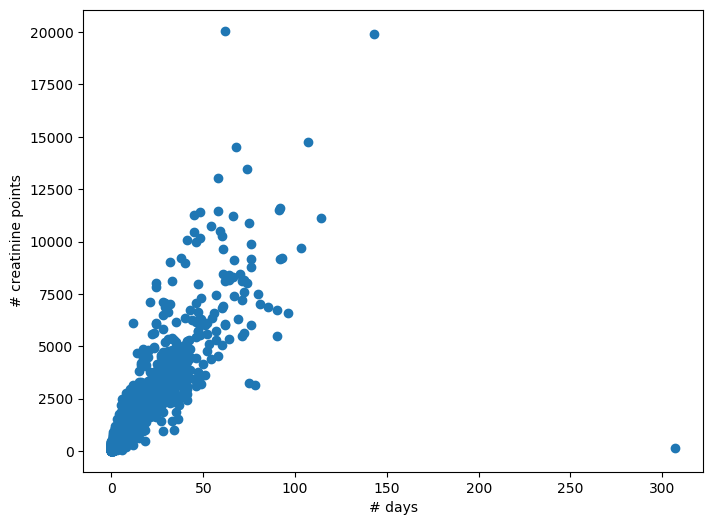

In [9]:
n_points = labresults_numeric.groupby('a_patientid').value.count().reset_index()

asd = patients.merge(n_points, how='inner', on='a_patientid')
asd['n_days'] = asd.distime.apply(lambda x: x // (60*24))
cols = ['a_patientid', 'n_days', 'value']
asd.loc[:, cols]

f, ax = plt.subplots(figsize=(8,6))

_ = ax.scatter(asd.n_days, asd.value)
_ = ax.set_xlabel('# days')
_ = ax.set_ylabel('# creatinine points')
plt.show()

In [10]:
idx = variables.query("hospital_coded==4").name.str.extract(r'(.*[Cc]reat\w+.*)').dropna().index.tolist()
variables.loc[idx]

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
chunk_0,,,,,,,,
15835,4,derived_numeric,4030014590,NaN,None,APACHE 2 serum creatinine,A2 S-Crea,APACHE II serum creatinine
15912,4,labresults_numeric,4020000600,NaN,None,Creatinina Serum,Creatinina,None
15967,4,labresults_numeric,4024001958,NaN,None,Creatina-fosfoquinasa,CPK,None
15968,4,labresults_numeric,4024001964,NaN,None,Creatinina-Plasma,Creatinina-P,None
16030,4,labresults_numeric,4024002443,NaN,None,Creatina-cinasa massa-Serum,CPK-MB,None
21259,4,observed_numeric,4010014605,NaN,None,Min 24 h serum creatinine,S-Crea min,Validated minimum 24 h serum creatinine
21260,4,observed_numeric,4010014610,NaN,None,Max 24 h serum creatinine,S-Crea max,Validated maximum 24 h serum creatinine


In [11]:
creat_idx = 4020000600
creatinine_4 = labresults_numeric.query(f"a_variableid=={creat_idx}")

cols = {'a_patientid':'a_patientid', 'time':'time_48', 'value':'value_48'}
cr48 = creatinine_4.loc[:, cols.keys()].rename(columns=cols)

m_48 = creatinine_4.merge(cr48, how='left', on=['a_patientid'])
m_48 = m_48.query("time_48 < time and time_48 > time - 2880")
m_48 = m_48.merge(creatinine_4, how='right', on=creatinine_4.columns.tolist())
m_48 = m_48.groupby(['a_patientid','a_variableid','time','value']).value_48.min().reset_index()

cols = {'a_patientid':'a_patientid', 'time':'time_7', 'value':'value_7'}
cr7 = creatinine_4.loc[:, cols.keys()].rename(columns=cols)

m_7 = creatinine_4.merge(cr7, how='left', on=['a_patientid'])
m_7 = m_7.query("time_7 < time and time_7 > time - 10080")
m_7 = m_7.merge(creatinine_4, how='right', on=creatinine_4.columns.tolist())
m_7 = m_7.groupby(['a_patientid','a_variableid','time','value']).value_7.min().reset_index()

kdigo_creatinine = m_48.merge(m_7, how='inner', on=['a_patientid', 'a_variableid', 'time', 'value'])

In [12]:
kdigo_creatinine.query("a_patientid==4000318")

,a_patientid,a_variableid,time,value,value_48,value_7
0,4000318,4020000600,1441,0.68,NaN,NaN
1,4000318,4020000600,2873,0.73,0.68,0.68
2,4000318,4020000600,4329,0.79,0.73,0.68
3,4000318,4020000600,5827,0.61,0.79,0.68
4,4000318,4020000600,7194,0.63,0.61,0.61
5,4000318,4020000600,11668,0.66,NaN,0.61
6,4000318,4020000600,12999,0.58,0.66,0.61
7,4000318,4020000600,14495,0.61,0.58,0.58
8,4000318,4020000600,15854,0.52,0.58,0.58
9,4000318,4020000600,17337,0.54,0.52,0.52


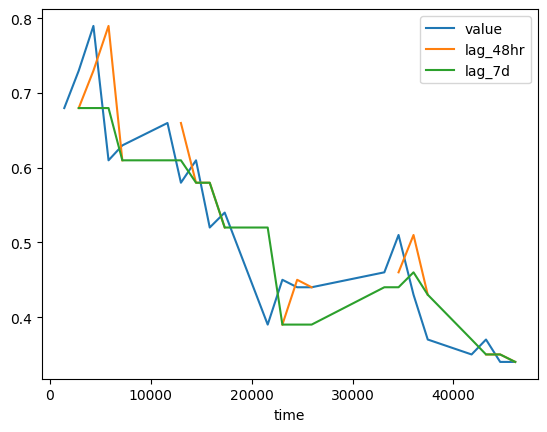

In [13]:
ax = kdigo_creatinine.query("a_patientid==4000318").plot(x='time', y='value', label='value')
_ = kdigo_creatinine.query("a_patientid==4000318").plot(x='time', y='value_48',ax=ax, label='lag_48hr')
_ = kdigo_creatinine.query("a_patientid==4000318").plot(x='time', y='value_7',ax=ax, label='lag_7d')

_ = ax.legend()

plt.show()

## Urine Output

In [14]:
idx = variables.query("hospital_coded==4").name.str.extract(r'(.*[Dd]i\wres\w+.*)').dropna().index.tolist()
variables.loc[idx]

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
chunk_0,,,,,,,,
16571,4,observed_categoric,4010002321,0.0,No,TISS-28 Active diuresis,T28Diur,None
16572,4,observed_categoric,4010002321,1.0,Yes,TISS-28 Active diuresis,T28Diur,None
16573,4,observed_categoric,4010002321,2.0,-,TISS-28 Active diuresis,T28Diur,None
16937,4,observed_categoric,4015001502,1.0,Colúrica,Aspecte Diüresi,Carac.diur,Característiques diüresi
16938,4,observed_categoric,4015001502,2.0,Hematúrica,Aspecte Diüresi,Carac.diur,Característiques diüresi
16939,4,observed_categoric,4015001502,3.0,Piúrica,Aspecte Diüresi,Carac.diur,Característiques diüresi
16940,4,observed_categoric,4015001502,4.0,Clara,Aspecte Diüresi,Carac.diur,Característiques diüresi
16941,4,observed_categoric,4015001502,5.0,Altres,Aspecte Diüresi,Carac.diur,Característiques diüresi
16942,4,observed_categoric,4015001502,6.0,Concentrada,Aspecte Diüresi,Carac.diur,Característiques diüresi


In [15]:
uro_idx = 4010010000

observed_numeric = pd.read_parquet('s3://icusics-db/observed_numeric/observed_numeric_h4.parquet')
urineOutput_4 = observed_numeric.query(f"a_variableid=={uro_idx}")
urineOutput_4

,a_patientid,a_variableid,time,value
13,4000592,4010010000,39,0.0
14,4000592,4010010000,394,360.0
15,4000592,4010010000,484,500.0
16,4000592,4010010000,604,500.0
17,4000592,4010010000,724,360.0
...,...,...,...,...
3220132,4991770,4010010000,2131,60.0
3220133,4991770,4010010000,2225,200.0
3220134,4991770,4010010000,2392,270.0
3220135,4991770,4010010000,2481,150.0


In [16]:
def get_lag(df, l, merge_idx=['a_patientid'], agg_fnc=np.sum, agg_col='value'):
    orig_cols = df.columns.tolist()
    custom_cols = list(map(lambda x: x + '_' + str(l) if x not in merge_idx else x, orig_cols))

    cols = {'time': f'time_{l}', 'value': f'value_{l}'}
    df_l = df.rename(columns=cols)

    m_l = df.merge(df_l, how='left', on=merge_idx)
    lhr = l * 60
    q_str = f"{cols['time']} < time and {cols['time']} > time - {lhr}"
    m_l = m_l.query(q_str)
    m_l = m_l.merge(df, how='right', on=df.columns.tolist())
    m_l = m_l.groupby(df.columns.tolist())[cols[agg_col]].apply(agg_fnc).reset_index()
    return m_l

In [17]:
u_patients = urineOutput_4.a_patientid.unique()

l6 = []
t6 = []
l12 = []
t12 = []
l24 = []
t24 = []

delta = 100
for i in tqdm(range(0, u_patients.shape[0], delta)):
    p_round = u_patients[i:i+delta]
    df = urineOutput_4[urineOutput_4.a_patientid.isin(p_round)].loc[:, ['a_patientid', 'time', 'value']]
    i6 = get_lag(df, l=6)
    i12 = get_lag(df, l=12)
    i24 = get_lag(df, l=24)
    j6 = get_lag(df, l=6, agg_col='time', agg_fnc=np.min)
    j12 = get_lag(df, l=12, agg_col='time', agg_fnc=np.min)
    j24 = get_lag(df, l=24, agg_col='time', agg_fnc=np.min)
    l6.append(i6)
    l12.append(i12)
    l24.append(i24)
    t6.append(j6)
    t12.append(j12)
    t24.append(j24)

100%|██████████| 40/40 [03:13<00:00,  4.85s/it]


In [18]:
uo_l6 = pd.concat(l6, ignore_index=True)
uo_l12 = pd.concat(l12, ignore_index=True)
uo_l24 = pd.concat(l24, ignore_index=True)

uo_t6 = pd.concat(t6, ignore_index=True)
uo_t12 = pd.concat(t12, ignore_index=True)
uo_t24 = pd.concat(t24, ignore_index=True)

uo_t6['uo_tm_6hr'] = (uo_t6.time - uo_t6.time_6) / 60
uo_t12['uo_tm_12hr'] = (uo_t12.time - uo_t12.time_12) / 60
uo_t24['uo_tm_24hr'] = (uo_t24.time - uo_t24.time_24) / 60

uo_t6 = uo_t6.drop(columns='time_6')
uo_t12 = uo_t12.drop(columns='time_12')
uo_t24 = uo_t24.drop(columns='time_24')

In [19]:
uo_m1 = uo_l6.merge(uo_l12, on=['a_patientid','time','value'])
uo_m2 = uo_m1.merge(uo_l24, on=['a_patientid','time','value'])
uo_m3 = uo_m2.merge(uo_t6, on=['a_patientid','time','value'])
uo_m4 = uo_m3.merge(uo_t12, on=['a_patientid','time','value'])
uo_m5 = uo_m4.merge(uo_t24, on=['a_patientid','time','value'])

In [20]:
patients_h4 = patients.query("hospital_coded==4").loc[:, ['a_patientid','weight']]
uo_m6 = uo_m5.merge(patients_h4, how='inner', on='a_patientid')
uo_m6['uo_rt_6hr'] = uo_m6.value_6 / uo_m6.weight / uo_m6.uo_tm_6hr
uo_m6['uo_rt_12hr'] = uo_m6.value_12 / uo_m6.weight / uo_m6.uo_tm_12hr
uo_m6['uo_rt_24hr'] = uo_m6.value_24 / uo_m6.weight / uo_m6.uo_tm_24hr

In [21]:
kdigo_uo = uo_m6.copy()

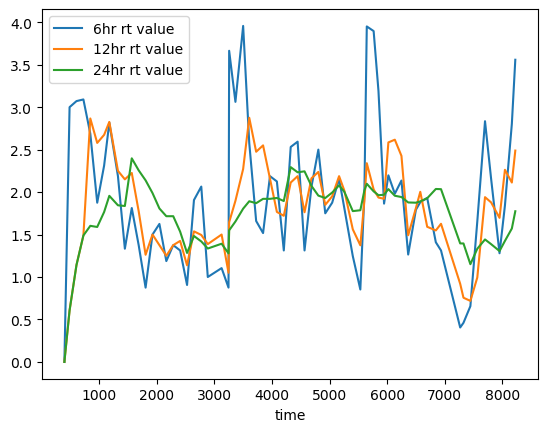

In [22]:
# ax = uo_m6.query('a_patientid==4000592').plot(x='time', y='value', label='value')
ax = uo_m6.query('a_patientid==4000592').plot(x='time', y='uo_rt_6hr', label='6hr rt value') #, ax=ax
_ = uo_m6.query('a_patientid==4000592').plot(x='time', y='uo_rt_12hr', ax=ax, label='12hr rt value')
_ = uo_m6.query('a_patientid==4000592').plot(x='time', y='uo_rt_24hr', ax=ax, label='24hr rt value')

_ = ax.legend()

plt.show()

## Stages

In [23]:
def creatine_stage(v, v48, v7):
    if (v >= v7*3) or ((v >= 4) and ((v48 <= 3.7) or (v >= 1.5*v7))):
        stage = 3
    elif (v >= v7*2):
        stage = 2
    elif (v >= v48+0.3) or (v >= 1.5*v7):
        stage = 1
    else:
        stage = 0
    return stage

In [24]:
aki_creat = list(map(lambda v,v48,v7: creatine_stage(v, v48, v7), kdigo_creatinine.value, kdigo_creatinine.value_48, kdigo_creatinine.value_7))
kdigo_creatinine['aki_stage_creat'] = aki_creat

In [25]:
cols = {'a_patientid':'a_patientid', 'time':'time', 
        'value':'creat', 'value_48':'creat_48hr', 'value_7':'creat_7days',
       'aki_stage_creat':'aki_stage_creat'}
kdigo_creatinine = kdigo_creatinine.loc[:, cols.keys()].rename(columns=cols)

In [26]:
def urineOut_stage(time, uo_tm_6hr, uo_tm_12hr, uo_tm_24hr, uo_rt_6hr, uo_rt_12hr, uo_rt_24hr):
    if (uo_rt_6hr  is None):
        stage = None
    elif time < 360:
        stage = 0
    elif ((uo_tm_24hr >= 11) and (uo_rt_24hr < 0.3)) or ((uo_tm_12hr >= 5) and (uo_rt_12hr == 0)):
        stage = 3
    elif (uo_tm_12hr >= 5) and (uo_rt_12hr < 0.5):
        stage = 2
    elif (uo_tm_6hr >= 2) and (uo_rt_6hr  < 0.5):
        stage = 1
    else:
        stage = 0
    return stage

In [27]:
kdigo_uo['aki_stage_uo'] = list(map(lambda t,tm6,tm12,tm24,rt6,rt12,rt24: urineOut_stage(t,tm6,tm12,tm24,rt6,rt12,rt24), 
        uo_m6.time, 
        uo_m6.uo_tm_6hr,
        uo_m6.uo_tm_12hr,
        uo_m6.uo_tm_24hr,
        uo_m6.uo_rt_6hr,
        uo_m6.uo_rt_12hr,
        uo_m6.uo_rt_24hr))

In [28]:
tm_stg = pd.concat(
    [kdigo_creatinine.loc[:, ['a_patientid','time']],
     kdigo_uo.loc[:, ['a_patientid','time']]
    ], ignore_index=True
)

In [29]:
kdigo_stages = patients.loc[:, ['a_patientid']].merge(tm_stg, how='left', on='a_patientid')
kdigo_stages = kdigo_stages.merge(kdigo_creatinine, how='left', on=['a_patientid','time'])
uo_cols = ['a_patientid','time','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage_uo']
kdigo_stages = kdigo_stages.merge(kdigo_uo.loc[:, uo_cols], how='left', on=['a_patientid','time'])

kdigo_stages['aki_stage'] = list(map(lambda x,y: max(x,y), kdigo_stages.aki_stage_creat.fillna(0).astype(float), kdigo_stages.aki_stage_uo.fillna(0).astype(float)))

kdigo_stages

,a_patientid,time,creat,creat_48hr,creat_7days,aki_stage_creat,uo_rt_6hr,uo_rt_12hr,uo_rt_24hr,aki_stage_uo,aki_stage
0,1000091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1000109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1000211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,1000999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,1001000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
352557,6998109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
352558,6998382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
352559,6998565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
352560,6998846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [50]:
kdigo_stages.to_csv('./kdigo_stages.csv')

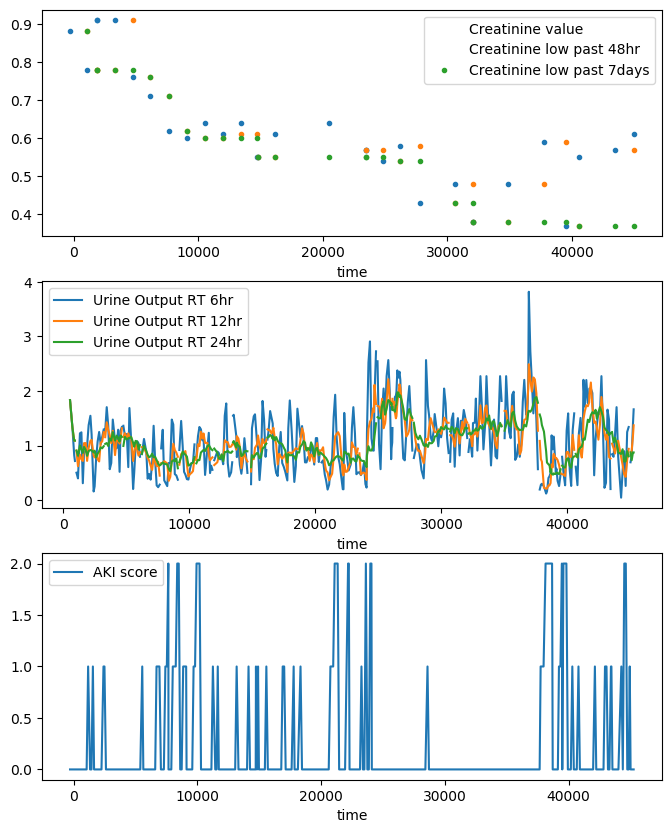

In [30]:
f, axs = plt.subplots(3,1,figsize=(8,10))
pz_tbl = kdigo_stages.query("a_patientid==4016104").sort_values(by='time')

_ = pz_tbl.plot(x='time', y='aki_stage', ax=axs[2], label='AKI score')
_ = pz_tbl.plot(x='time', y='creat', style='.', ax=axs[0], label='Creatinine value')
_ = pz_tbl.plot(x='time', y='creat_48hr', style='.', ax=axs[0], label='Creatinine low past 48hr')
_ = pz_tbl.plot(x='time', y='creat_7days', style='.', ax=axs[0], label='Creatinine low past 7days')
_ = pz_tbl.plot(x='time', y='uo_rt_6hr', ax=axs[1], label='Urine Output RT 6hr')
_ = pz_tbl.plot(x='time', y='uo_rt_12hr', ax=axs[1], label='Urine Output RT 12hr')
_ = pz_tbl.plot(x='time', y='uo_rt_24hr', ax=axs[1], label='Urine Output RT 24hr')
plt.show()

## Get predictors

Albumine, Potassium, SaO2, Haematocrit, Creatinine, Ph

In [31]:
# Albumine
idx = variables.name.str.lower().str.extract(r'(.*\balbu\w+.*)').dropna().index.tolist()
variables.loc[idx]

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
chunk_0,,,,,,,,
363,1,labresults_numeric,1024000684,NaN,None,S-Albumina,S-Albumina,None
16011,4,labresults_numeric,4024002341,NaN,None,Albumina-Sèrum,Albumina,None


In [32]:
# Potassium
idx = variables.name.str.lower().str.extract(r'(.*\bpotas\w+.*)').dropna().index.tolist()
variables.loc[idx].query("hospital_coded==4")

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
chunk_0,,,,,,,,
15791,4,derived_numeric,4030005310,NaN,None,Cum potassium intake,IN K/c,None
15834,4,derived_numeric,4030014580,NaN,None,APACHE 2 serum potassium,A2 S-K,APACHE II serum potassium
15842,4,derived_numeric,4030014660,NaN,None,S2 serum potassium,S2 S-K,SAPS II serum potassium
15872,4,derived_numeric,4030015310,NaN,None,Daily potassium intake,IN K/d,None
15911,4,labresults_numeric,4020000500,NaN,None,Potassi Sèrum,Potassi,None
15981,4,labresults_numeric,4024002036,NaN,None,Potassi-Plasma,Potassi-P,None
21257,4,observed_numeric,4010014595,NaN,None,Min 24 h serum potassium,S-K min,Validated minimum 24 h serum potassium
21258,4,observed_numeric,4010014600,NaN,None,Max 24 h serum potassium,S-K max,Validated maximum 24 h serum potassium


In [33]:
# SaO2
idx = variables.name.str.lower().str.extract(r'(.*(\bspo2\b|\bsatura\w+).*)')[0].dropna().index.tolist()
variables.loc[idx].query("hospital_coded==4")

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
chunk_0,,,,,,,,
15766,4,derived_numeric,4030003500,NaN,None,SpO2/FiO2 ratio,SpO2/FiO2,"= SpO2 / FiO2 ; SpO2 %, FiO2 %/100 (2 h)"
16047,4,labresults_numeric,4024002588,NaN,None,Index saturació transferrina,Sat transfer,None
16254,4,monitored_numeric,4000004000,NaN,None,SpO2,SpO2,SatO2 perifèrica
16256,4,monitored_numeric,4000004311,NaN,None,Saturació O2 Regió 1,Sr1O2,None
16257,4,monitored_numeric,4000004312,NaN,None,Saturació O2 Regió 2,Sr2O2,None
16258,4,monitored_numeric,4000004313,NaN,None,Saturació O2 Regió 3,Sr3O2,None
16259,4,monitored_numeric,4000004314,NaN,None,Saturació O2 Regió 4,Sr4O2,None
21350,4,observed_numeric,4015003101,NaN,None,Saturació d'hemoglobina,SatHb preIET,abans de la intubació traqueal


In [34]:
# Haematocrit
idx = variables.name.str.lower().str.extract(r'(.*ha?emat\w+.*)')[0].dropna().index.tolist()
variables.loc[idx].query("hospital_coded==4")

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
chunk_0,,,,,,,,
15828,4,derived_numeric,4030014540,NaN,None,APACHE 2 hematocrit,A2 B-Hcr,APACHE II hematocrit
15907,4,labresults_numeric,4020000100,NaN,None,Hematòcrit,Hematòcrit,None
15999,4,labresults_numeric,4024002245,NaN,None,Hematies,Hematies,None
16750,4,observed_categoric,4014000210,1.0,No,Hematologic malignancy,Hem maligncy,SAPS II and SAPS 3 comorbid condition
16751,4,observed_categoric,4014000210,2.0,Yes,Hematologic malignancy,Hem maligncy,SAPS II and SAPS 3 comorbid condition
17470,4,observed_categoric,4015002317,1.0,-,Hematúria,Sang orina,None
17471,4,observed_categoric,4015002317,2.0,+,Hematúria,Sang orina,None
17472,4,observed_categoric,4015002317,3.0,++,Hematúria,Sang orina,None
17473,4,observed_categoric,4015002317,4.0,+++,Hematúria,Sang orina,None


In [37]:
# Ph
idx = variables.name.str.lower().str.extract(r'(.*ph.*)')[0].dropna().index.tolist()
variables.loc[idx].query("hospital_coded==4")

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
chunk_0,,,,,,,,
15832,4,derived_numeric,4030014560,NaN,None,APACHE 2 art pH,A2 pHa,APACHE II arterial pH
15931,4,labresults_numeric,4024001491,NaN,None,pH,pH,None
15949,4,labresults_numeric,4024001725,NaN,None,Ven-pH,Ven-pH,None
16061,4,labresults_numeric,4024002679,NaN,None,pH(T),pH(T),None
16260,4,monitored_numeric,4000004510,NaN,None,Gastric intramucosal pH,pHi,pH intramucosal gàstric
17459,4,observed_categoric,4015002315,1.0,5,pH orina,pH orina,None
17460,4,observed_categoric,4015002315,2.0,6,pH orina,pH orina,None
17461,4,observed_categoric,4015002315,3.0,"6,5",pH orina,pH orina,None
17462,4,observed_categoric,4015002315,4.0,7,pH orina,pH orina,None


In [38]:
# Blood Urine Nitrate
# urea * 0.357
idx = variables.name.str.lower().str.extract(r'(.*urea.*)')[0].dropna().index.tolist()
variables.loc[idx].query("hospital_coded==4")

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
chunk_0,,,,,,,,
15839,4,derived_numeric,4030014630,NaN,None,S2 serum urea,S2 S-Urea,SAPS II serum urea
15919,4,labresults_numeric,4020004100,NaN,None,Urea Sèrum,Urea,None
15989,4,labresults_numeric,4024002104,NaN,None,Urea-Plasma,Urea-P,None
21265,4,observed_numeric,4010014635,NaN,None,Max 24 h serum urea,S-Urea max,Validated maximum 24 h serum urea


In [39]:
# Diabetes
idx = diagnoses.referencecodename.str.extract(r'(.*[Dd]iabe.*)').dropna().index.tolist()
diabetes_codes = diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates().referencecode

In [40]:
# Chronic Kidney Disease
idx = diagnoses.referencecodename.str.lower().str.extract(r'(.*renal cr\wnica.*)').dropna().index.tolist()
ckd_codes = diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates().referencecode

In [41]:
# Hyper tension
idx = diagnoses.referencecodename.str.lower().str.extract(r'(.*hipertens.*)').dropna().index.tolist()
diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates()#.referencecodename.value_counts()

,referencecode,referencecodename
6,I10,Hipertensió essencial
9,I16.9,Crisi hipertensiva no especificada
10,I10,Hipertensió (primària) essencial
274,G93.5,Hipertensió intracranial
464,401.9,Hipertensió essencial
585,K76.6,Hipertensió portal
737,401.1,Hipertensió essencial benigna
1099,I15.8,Altres tipus d´hipertensió secundària
1167,I27.2,Altres tipus d´hipertensió pulmonar secundària
1547,I27.0,Hipertensió pulmonar primària


In [42]:
# Heart failure
idx = diagnoses.referencecodename.str.lower().str.extract(r'(.*insufici\wncia card\waca.*)').dropna().index.tolist()
diagnoses.loc[idx, ['referencecode','referencecodename']].drop_duplicates()#.referencecodename.value_counts()

,referencecode,referencecodename
94,I50,Insuficiència cardíaca
176,I50.9,Insuficiència cardíaca congestiva
1206,428.0,Insuficiència cardíaca congestiva
2360,402.11,Cardiopatia hipertensiva benigna a/insuficiènc...
5050,I50.2,Insuficiència cardíaca (congestiva) sistòlica
5203,I13.1,Cardiopatia hipertensiva i mal. renal crònica ...
5837,I50.9,Insuficiència cardíaca no especificada
7921,I11.9,Cardiopatia hipertensiva sense insuficiència c...
9330,I11.0,Cardiopatia hipertensiva amb insuficiència car...


In [51]:
diagnosis_codes = [
    # diabetes_codes
    # ckd_codes
    'I10','401.1','402.11','I15.8','I15.0','I11','I15','I13.1','I11.9','I15.1','I11.0','I11.0','401.9' # hyptertension
    'I50','I50.9','428.0','402.11','I50.2','I50.9','I11.0' # heart failure
] + list(diabetes_codes) + list(ckd_codes)

comorbidities = diagnoses[diagnoses.referencecode.isin(diagnosis_codes)]

In [52]:
comorbidities.to_csv('./comorbidities.csv')

In [44]:
# CRRT
idx = variables.name.str.lower().str.extract(r'(.*flux.*)')[0].dropna().index.tolist()
variables.loc[idx].query("hospital_coded==4")

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
chunk_0,,,,,,,,
16079,4,monitored_categoric,4000003824,1.0,ACCEL,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16080,4,monitored_categoric,4000003824,2.0,SQUARE,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16081,4,monitored_categoric,4000003824,3.0,50%DEC,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16082,4,monitored_categoric,4000003824,4.0,DECEL,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16083,4,monitored_categoric,4000003824,5.0,50%ACCEL,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16084,4,monitored_categoric,4000003824,6.0,MOD.SINE,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16085,4,monitored_categoric,4000003824,7.0,SINE,Patró de fluxe Hamilton,Hamilton Pat,Patró de fluxe Hamilton
16142,4,monitored_categoric,4000009541,6.0,RAMP,Tipus Corba Flux Inspiratori,PB840 Ptrn,None
16143,4,monitored_categoric,4000009541,7.0,SQUARE,Tipus Corba Flux Inspiratori,PB840 Ptrn,None


In [45]:
outcome_items = [
    4000001380, # Flux Sang	
    4000005666, # Flux Efluent	
]

In [46]:
lab_items = [
    4024002341, # Albumine
    4020000500, # Potassium
    4020000100, # Haematocrit
    4024001491, # Ph
    4020004100, # BUN
]

lab_predictors = labresults_numeric[labresults_numeric.a_variableid.isin(lab_items)]
lab_predictors

,a_patientid,a_variableid,time,value
0,4004981,4020000100,-478,39.30
1,4004981,4020000100,343,28.20
2,4004981,4020000100,1821,28.50
3,4004981,4020000100,3161,29.30
4,4004981,4020000100,4581,28.60
...,...,...,...,...
3615092,4991748,4020000100,922,44.50
3615095,4991748,4020000500,922,4.23
3615101,4991748,4020004100,932,17.00
3615118,4991748,4024001491,81,7.34


In [47]:
lab_predictors = lab_predictors.merge(variables.loc[:, ['a_variableid','abbreviation']], how='left', on='a_variableid')

In [54]:
lab_predictors.to_csv('./labs.csv')

In [48]:
vital_items = [
    4000004000, # SpO2
]

outcome_items = [
    4000001380, # Flux Sang
    4000005666, # Flux Efluent
]

monitored_predictors = []
outcomes = []

monitored_tables = tables[tables.str.match(r'monitored_numeric/monitored_numeric_4')]
for table in tqdm(monitored_tables):
    t_ith = pd.read_parquet(f"s3://icusics-db/{table}")
    v_ith = t_ith[t_ith.a_variableid.isin(vital_items)]
    o_th = t_ith[t_ith.a_variableid.isin(outcome_items)]
    monitored_predictors.append(v_ith)
    outcomes.append(o_th)
    
monitored_predictors = pd.concat(monitored_predictors, ignore_index=True)
outcomes = pd.concat(outcomes, ignore_index=True)
outcomes

100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


,a_patientid,a_variableid,time,value
0,4003958,4000001380,64497,70.0
1,4003958,4000001380,64512,70.0
2,4003958,4000001380,64527,70.0
3,4003958,4000001380,64542,70.0
4,4003958,4000001380,64572,70.0
...,...,...,...,...
267007,4995531,4000001380,470,200.0
267008,4995531,4000005666,306,3050.0
267009,4995531,4000005666,470,3050.0
267010,4997421,4000001380,1965,180.0


In [55]:
monitored_predictors = monitored_predictors.merge(variables.loc[:, ['a_variableid','abbreviation']], how='left', on='a_variableid')

In [56]:
monitored_predictors.to_csv('./vitals.csv')

In [60]:
time_window = 12 * 60

labs = lab_predictors.query(f"time<={time_window}")
vitals = monitored_predictors.query(f"time<={time_window}")

vitals = pd.pivot_table(
    vitals,
    index='a_patientid',
    columns='abbreviation_x',
    values='value',
    aggfunc=[min,max]
).reset_index()

labs = pd.pivot_table(
    labs,
    index='a_patientid',
    columns='abbreviation',
    values='value',
    aggfunc=[min,max]
).reset_index()

labs

# features = vitals.merge(labs, how='inner', on='a_patientid')

a_patientid      min                                      max  \
abbreviation             Albumina Hematòcrit Potassi   Urea    pH Albumina   
0                4000318      NaN       39.5     NaN    NaN  7.35      NaN   
1                4000422      3.9       34.3    4.09   83.0  7.16      3.9   
2                4000555      NaN       49.6     NaN    NaN  7.26      NaN   
3                4000561      4.5       51.3    3.97   27.0  7.38      4.5   
4                4000592      2.9       36.7    4.00   67.0  7.27      2.9   
...                  ...      ...        ...     ...    ...   ...      ...   
3820             4999651      NaN       30.5     NaN    NaN  7.42      NaN   
3821             4999848      NaN       28.5    4.63   97.0  7.32      NaN   
3822             4999872      NaN       32.0    3.25   25.0  7.44      NaN   
3823             4999880      2.9       24.1    5.61  122.0  7.34      3.1   
3824             4999885      NaN       42.1     NaN    NaN  7.40      NaN   

                                              
abbreviation Hematòcrit Potassi   Urea    pH  
0                  39.5     NaN    NaN  7.35  
1                  34.3    4.09   83.0  7.17  
2                  49.6     NaN    NaN  7.44  
3                  51.3    3.97   27.0  7.40  
4                  41.9    4.57   68.0  7.43  
...                 ...     ...    ...   ...  
3820               30.5     NaN    NaN  7.44  
3821               32.6    4.92  100.0  7.34  
3822               32.0    3.25   25.0  7.44  
3823               26.6    5.80  127.0  7.34  
3824               42.1     NaN    NaN  7.42  

[3825 rows x 11 columns]

In [61]:
labs.to_csv('./pivoted_labs.csv')
vitals.to_csv('./pivoted_vitals.csv')

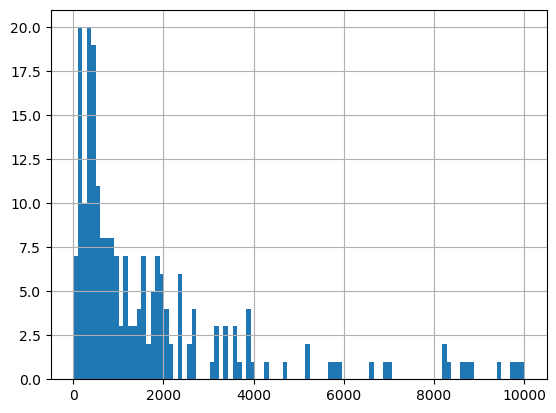

In [144]:
b = np.linspace(0,10_000,100)
ax = outcomes.groupby('a_patientid').time.min().hist(bins=b)
plt.show()

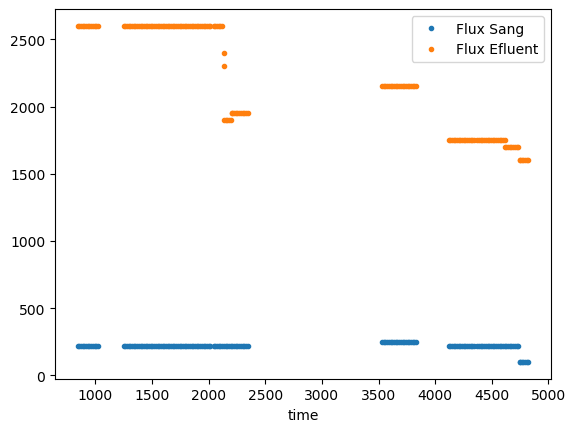

In [145]:
pz_id = 4791469
ax = outcomes.query(f"a_patientid=={pz_id} and a_variableid==4000001380").sort_values(by='time').plot(x='time', y='value', style='.', label='Flux Sang') #Flux Sang
_ = outcomes.query(f"a_patientid=={pz_id} and a_variableid==4000005666").sort_values(by='time').plot(x='time', y='value', style='.', ax=ax, label='Flux Efluent') #Flux Sang
_ = ax.legend()
plt.show()

In [63]:
target = pd.pivot_table(
    outcomes,
    index=['a_patientid','time'],
    columns=['a_variableid'],
    values='value'
).reset_index()

target = target.rename(columns={4000001380:'flux_sang', 4000005666:'flux_efluent'})
target

a_variableid,a_patientid,time,flux_sang,flux_efluent
0,4002523,489,200.0,3002.0
1,4002523,534,200.0,3052.0
2,4002523,774,200.0,3052.0
3,4002523,834,200.0,3052.0
4,4002523,954,200.0,3052.0
...,...,...,...,...
135891,4996001,90079,100.0,202.0
135892,4996001,90094,100.0,202.0
135893,4996001,90109,100.0,202.0
135894,4996001,90124,100.0,202.0


In [64]:
target['Y'] = list(map(lambda x,y: 1 if x>=0 and y>=0 else 0, target.flux_sang.fillna(-1), target.flux_efluent.fillna(-1)))  
target

a_variableid,a_patientid,time,flux_sang,flux_efluent,Y
0,4002523,489,200.0,3002.0,1
1,4002523,534,200.0,3052.0,1
2,4002523,774,200.0,3052.0,1
3,4002523,834,200.0,3052.0,1
4,4002523,954,200.0,3052.0,1
...,...,...,...,...,...
135891,4996001,90079,100.0,202.0,1
135892,4996001,90094,100.0,202.0,1
135893,4996001,90109,100.0,202.0,1
135894,4996001,90124,100.0,202.0,1


In [65]:
target.to_csv('./target.csv')

# Aggregation

In [2]:
import pandas as pd

In [5]:
aki_scores  = pd.read_csv('./kdigo_stages.csv', index_col=0)
labs = pd.read_csv('./pivoted_labs.csv', index_col=0)
vitals = pd.read_csv('./pivoted_vitals.csv', index_col=0)
target = pd.read_csv('./target.csv', index_col=0)
comorbidities = pd.read_csv('./comorbidities.csv', index_col=0)

In [8]:
labs.columns

Index(['a_patientid', 'min', 'min.1', 'min.2', 'min.3', 'min.4', 'max',
       'max.1', 'max.2', 'max.3', 'max.4'],
      dtype='object')